# Eyeblink correction


So let's say you have some data from the stream and have saved it into a (temporary) file, such as can be found in:

**/home/rt/nf/nf-rtime/Tutorials/savedfiles/example.fif**

In order to do an eyeblink correction, you'd wish to load that data in, perhaps inspect it, then run an ICA, and then use the ICA weights for spatially filtering the real-time data stream coming in later.

First we load in the example data

In [1]:
filename = '/home/rt/nf/nf-rtime/Tutorials/savedfiles/example.fif'

In [2]:
import mne

In [3]:
raw=mne.io.read_raw_fif(filename)

Opening raw data file /home/rt/nf/nf-rtime/Tutorials/savedfiles/example.fif...
    Range : 0 ... 179974 =      0.000 ...   179.974 secs
Ready.


<ipython-input-3-ffab7c54e237>:1: RuntimeWarning: This filename (/home/rt/nf/nf-rtime/Tutorials/savedfiles/example.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw=mne.io.read_raw_fif(filename)


ok we violate MNE's naming convention but we still load it in

In [4]:
%matplotlib qt

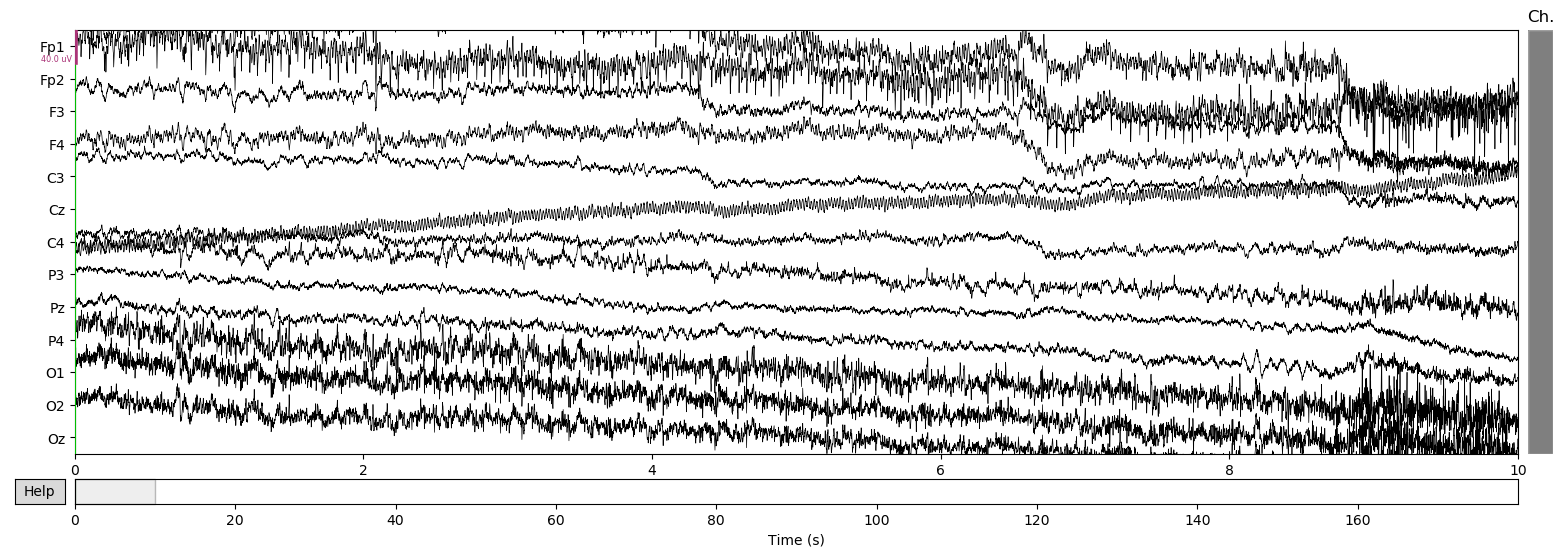

In [5]:
raw.plot()

Check the data between 96 and 111 - ideal for detecting eyeblinks, since here we instructed the participant to actually blink a couple of times

In theory it is ideal, except for when the participant misunderstands... (we had one case of this happening)

Now we can do ICA, as per shown in the MNE Turorials web page:
[https://mne.tools/stable/auto_tutorials/index.html](https://mne.tools/stable/auto_tutorials/index.html)

subsection 'Repairing artifacts with ICA'

In [6]:
# and let's do the ICA

from mne.preprocessing import ICA

In [7]:
ica=ICA(max_pca_components=12)

ica.fit(raw, start=0.0, stop=111.0)

Fitting ICA to data using 13 channels (please be patient, this may take a while)
Using all PCA components: 12
Fitting ICA took 12.4s.


<ICA  |  raw data decomposition, fit (fastica): 111000 samples, 12 components, channels used: "eeg">

now we compare sensor space

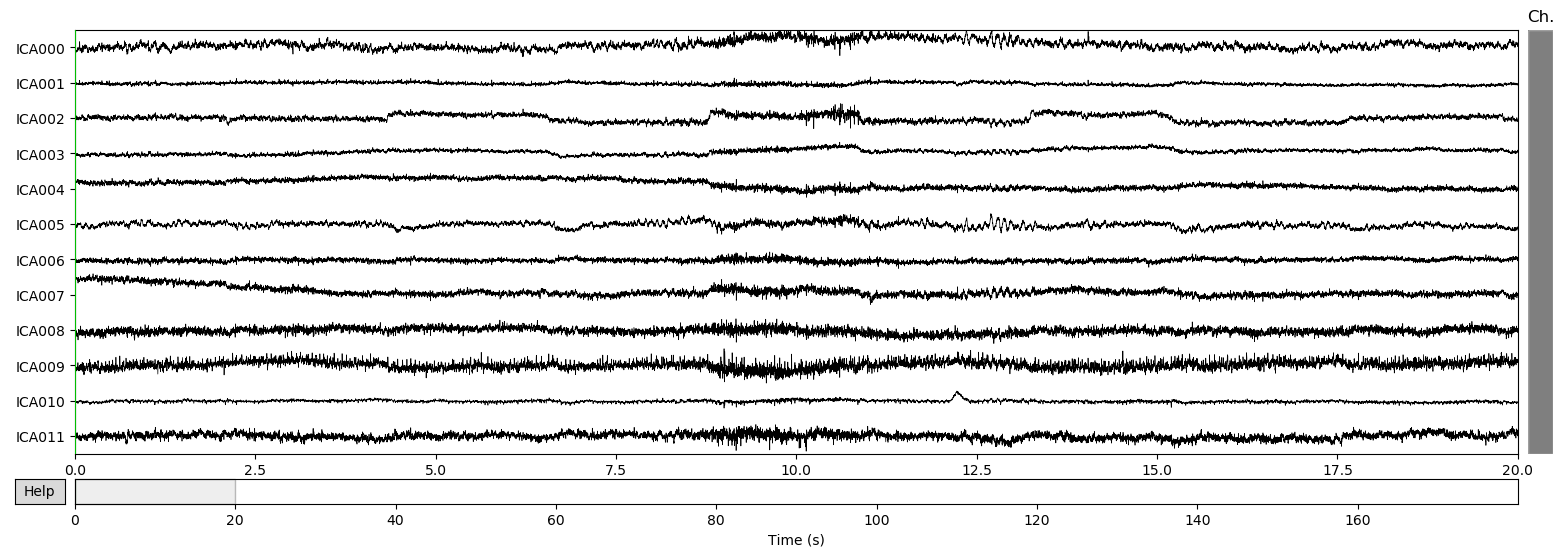

In [8]:
ica.plot_sources(raw)

So probably component number 1 and maybe 2 (not 2 and 3 - it starts with 0). It depends on the current ICA run if it's always component 2, since there is some randomization going on when you calculate an ICA. So basically you'd always have to eyeball it. Or write a nice way to 'learn' what a typical eyeblink component looks like within the current EEG system that you have.

We can also plot components as a topographical image

In [61]:
ica.plot_components()


[<Figure size 750x550 with 15 Axes>]

And we can tell ica to exclude them:

In [9]:
ica.exclude = [1, 10]

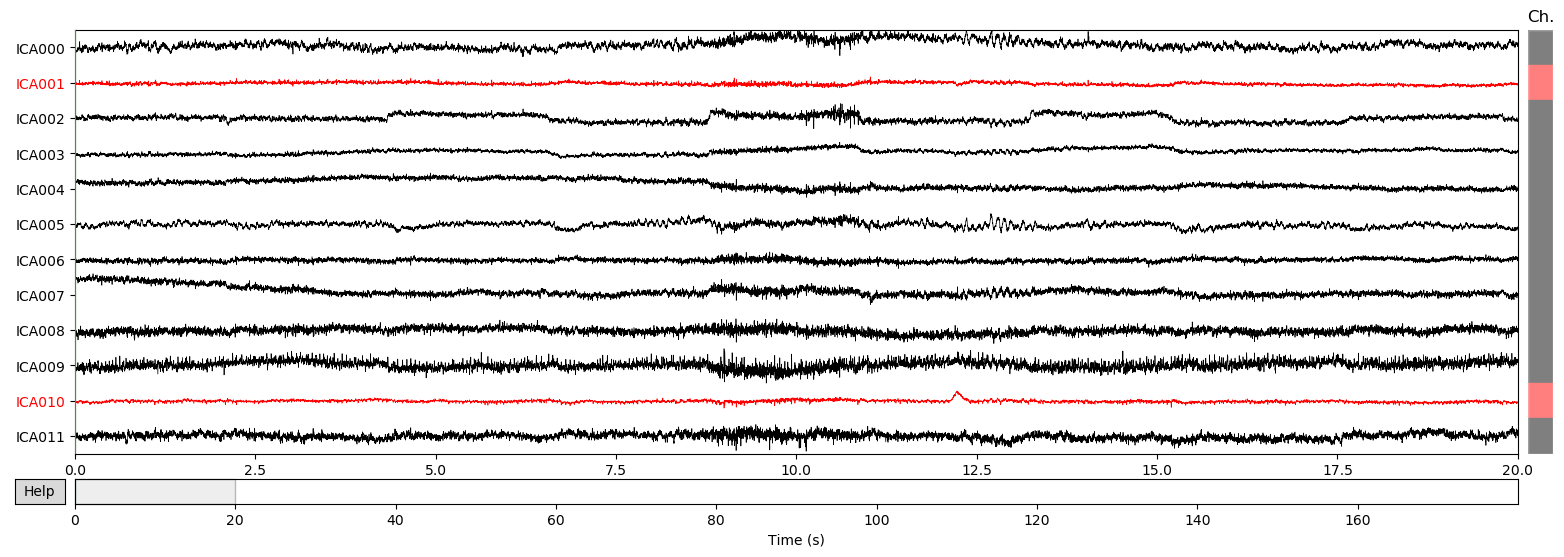

In [10]:
ica.plot_sources(raw)

Some check to see if it works to project out this component

In [11]:
# apply it -- and compare raw vs raw_with_ica_applied
raw_after_ica = raw.copy()

In [12]:
raw_after_ica.load_data()  # we need to load it into memory
                           # as ica doens't work on a memory-mapped file

Reading 0 ... 179974  =      0.000 ...   179.974 secs...


<Raw  |  example.fif, n_channels x n_times : 13 x 179975 (180.0 sec), ~17.9 MB, data loaded>

In [14]:
ica.exclude=[1, 10]

In [15]:
ica.apply(raw_after_ica)

Transforming to ICA space (12 components)
Zeroing out 2 ICA components


<Raw  |  example.fif, n_channels x n_times : 13 x 179975 (180.0 sec), ~17.9 MB, data loaded>

Compare!

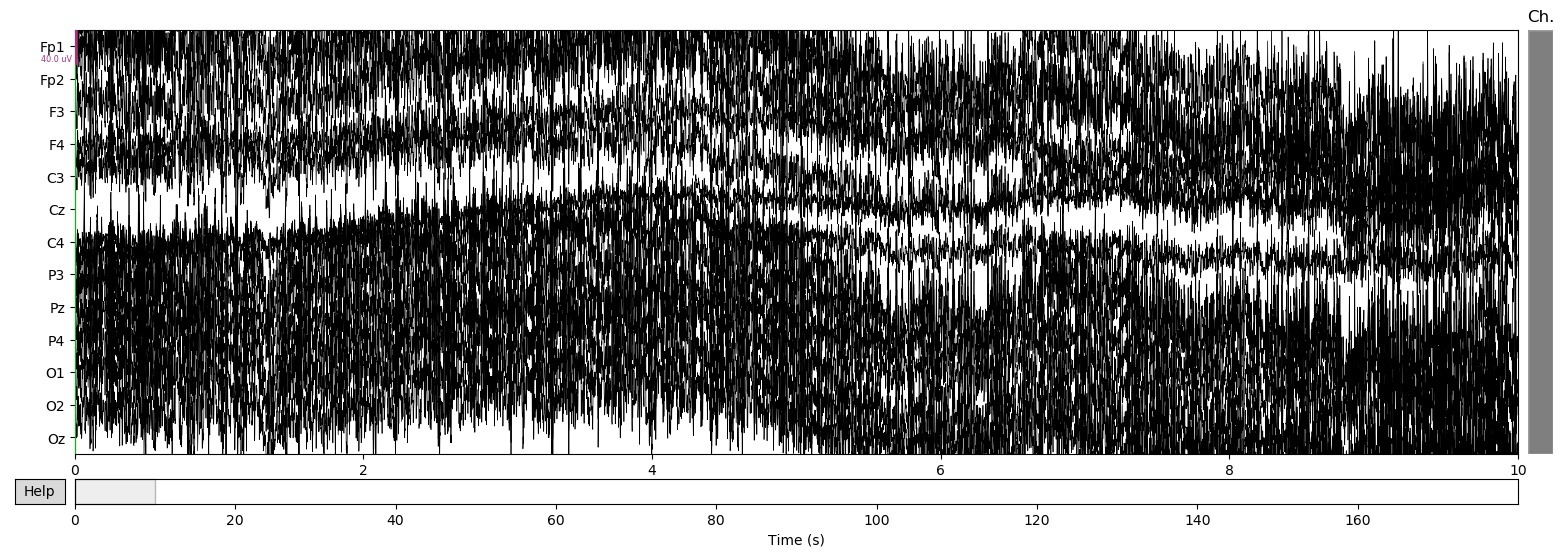

In [16]:
raw_after_ica.plot()

In [19]:
# so that works - and everything we need is in the ica object.
ica.pca_mean_

array([-2.20075064, -4.257807  , -1.62769165, -2.45481754, -0.4706606 ,
       -1.16866147, -0.85447901, -2.52602545, -1.53353977, -0.69447124,
       -2.11703033, -0.8789126 , -0.96773715])

we can save the ica parameters, so we can load them back in at a later time

In [22]:
ica.save('savedfiles/parameters-ica.fif')

Writing ICA solution to savedfiles/parameters-ica.fif...


<ICA  |  raw data decomposition, fit (fastica): 111000 samples, 12 components, channels used: "eeg", 2 sources marked for exclusion>

### test it myself

using documentations from here:
[https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA](https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA)

In [58]:
mydata = raw.get_data()

In [59]:
import numpy as np
import matplotlib.pyplot as plt

In [60]:
# apply the spatial filter:
# in order to do ICA on our own data, we need the following:

Sc = ica.pre_whitener_

pM = ica.pca_mean_[:, None]
PCA = ica.pca_components_

iMix = ica.mixing_matrix_
iUnmix = ica.unmixing_matrix_

Sel = np.eye(ica.n_components_)
Sel[:, ica.exclude] = 0

In [61]:
cordata = (PCA.T @ iMix @ Sel @ iUnmix @ PCA @ (mydata / Sc - pM) + pM) * Sc

In [62]:
# plot raw and ICA'ed data:
plt.figure()
plt.plot(mydata[0, 96000:110000])
plt.title('no ica')

plt.figure()
plt.plot(cordata[0, 96000:110000])
plt.title('ica')

Text(0.5, 1.0, 'ica')

So be cafeful with applying ICA, especially if you have few channels!
We probably need more channels (13 is a bit low); or more data; or perhaps some pre-prepcessing on the data


but... we can apply this operation also on only a small subsection of data

In [65]:
dpart = mydata[:, :100]

In [66]:
cdpart = (PCA.T @ iMix @ Sel @ iUnmix @ PCA @ (dpart / Sc - pM) + pM) * Sc

so we can apply this ICA method directly 'on-line':

In [1]:
import pylsl
import sys
sys.path.append("/home/rt/nf/nfb")
sys.path.append("/home/rt/nf/nfb/pynfb")

import time  
import widgets
from widgets.signal_viewers import SignalViewer
from widgets.signal_viewers import RawSignalViewer

streams=pylsl.resolve_streams()
inlet=pylsl.stream_inlet(streams[0])


inlet_info = inlet.info()
nchans = inlet_info.channel_count()
srate = inlet_info.nominal_srate()

print(nchans)
print(srate)

13
1000.0


In [2]:
# make the RawSignalViewer with that many channels
w1=RawSignalViewer(srate,['%d' % i for i in range(nchans)])
w2=RawSignalViewer(srate,['%d' % i for i in range(nchans)])

/home/rt/nf/nfb/pynfb/static/imag/right-arrow.png
/home/rt/nf/nfb/pynfb/static/imag/left-arrow.png
/home/rt/nf/nfb/pynfb/static/imag/right-arrow.png
/home/rt/nf/nfb/pynfb/static/imag/left-arrow.png


In [3]:
w1.show()
w2.show()

we can read in the data ICA parameters

In [4]:
import mne
import numpy as np
ica=mne.preprocessing.read_ica('savedfiles/parameters-ica.fif')

Reading savedfiles/parameters-ica.fif ...
Now restoring ICA solution ...
Ready.


In [5]:
# apply the spatial filter:
# in order to do ICA on our own data, we need the following:

Sc = ica.pre_whitener_

pM = ica.pca_mean_[:, None]
PCA = ica.pca_components_

iMix = ica.mixing_matrix_
iUnmix = ica.unmixing_matrix_

Sel = np.eye(ica.n_components_)
Sel[:, ica.exclude] = 0

In [ ]:
while True:
    
    time.sleep(0.00001)
    data_chunk, times = inlet.pull_chunk()
    
    if data_chunk:
    
        d = np.asarray(data_chunk)
        ica_d = ((PCA.T @ iMix @ Sel @ iUnmix @ PCA @ (d.T / Sc - pM) + pM) * Sc).T
        w1.update(d)
        w2.update(ica_d)

